In [1]:
!pip install fbprophet

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import numpy as np
sns.set()

from fbprophet import Prophet
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = '/content/drive/My Drive/'
#file = 'SCADA_data_WT2339.csv'
file = 'SCADA_data_WT1198.csv'
df_raw = pd.read_csv(path+file,
                   low_memory=False)
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'], format="%Y/%m/%d %H:%M:%S")
df_raw = df_raw.sort_values(by='date_time')
df_raw.tail()

,id,ld_id,date_time,fake_data,TimeStamp,scadaplant,scadadevice,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContAlarmErrMean,ContAlarmErrSdev,ContAlarmErrMin,ContAlarmErrMax,ContAmbErrMean,ContAmbErrSdev,ContAmbErrMin,ContAmbErrMax,ContCurtailMean,ContCurtailSdev,ContCurtailMin,...,Top_Alm4Mean,Top_Alm4Sdev,Top_Alm4Min,Top_Alm4Max,Top_Alm6Mean,Top_Alm6Sdev,Top_Alm6Min,Top_Alm6Max,Top_Alm8Mean,Top_Alm8Sdev,Top_Alm8Min,Top_Alm8Max,Top_Alm9Mean,Top_Alm9Sdev,Top_Alm9Min,Top_Alm9Max,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,VelVientoPruebaMean,VelVientoPruebaSdev,VelVientoPruebaMin,VelVientoPruebaMax,YawMean,YawSdev,YawMin,YawMax
349633,40347810,1198,2019-10-28 01:10:00,0,NaN,NaN,NaN,600,225.191,2.30056,213.697,226.937,227.932,2.49296,215.306,229.347,225.795,2.60925,213.646,228.222,0.0,NaN,NaN,NaN,NaN,539649000.0,17214400.0,537402000.0,671620000.0,47808.0,0.0,47808.0,47808.0,607323.0,0.0,607323.0,607323.0,28947.0,0.0,28947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-195.807,4.25065,-206.0,-186.0,949.022,22.5807,926.16,1000.92,12.1530,0.326327,11.61,12.96,5.96327,0.506321,4.47993,7.41022,NaN,NaN,NaN,NaN,215.668,0.934137,214.000,216.735
349634,40347811,1198,2019-10-28 01:20:00,0,NaN,NaN,NaN,600,224.819,3.39826,212.633,226.776,226.659,3.55342,214.400,229.026,224.790,3.63413,212.150,228.062,0.0,NaN,NaN,NaN,NaN,541886000.0,24116500.0,537402000.0,671620000.0,47808.0,0.0,47808.0,47808.0,607323.0,0.0,607323.0,607323.0,28947.0,0.0,28947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-207.509,10.74470,-229.0,-188.0,1119.570,113.9210,937.32,1248.60,14.3598,1.471050,11.89,16.32,7.28624,0.852035,5.50827,8.70511,NaN,NaN,NaN,NaN,223.448,3.632500,216.735,226.000
349635,40347812,1198,2019-10-28 01:30:00,0,NaN,NaN,NaN,600,225.600,2.62263,211.508,226.776,228.107,2.65674,213.436,228.967,226.043,3.06280,210.865,228.222,0.0,NaN,NaN,NaN,NaN,540767000.0,20979100.0,537402000.0,671620000.0,47808.0,0.0,47808.0,47808.0,607323.0,0.0,607323.0,607323.0,28947.0,0.0,28947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-234.548,5.97280,-250.0,-217.0,1226.230,16.1159,1149.36,1244.76,15.7138,0.256812,14.49,16.27,8.10656,0.309393,7.00041,9.09691,NaN,NaN,NaN,NaN,230.345,0.742383,225.908,231.000
349636,40347813,1198,2019-10-28 01:40:00,0,NaN,NaN,NaN,600,225.929,2.03132,213.210,226.776,228.352,2.20762,214.355,229.347,226.429,2.37967,211.681,228.383,0.0,NaN,NaN,NaN,NaN,553112000.0,43146900.0,537402000.0,671620000.0,47808.0,0.0,47808.0,47808.0,607323.0,0.0,607323.0,607323.0,28947.0,0.0,28947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-235.688,3.92110,-246.0,-225.0,1169.420,28.9036,1116.60,1248.96,15.0104,0.423721,14.01,16.32,7.59101,0.392897,6.22896,8.71939,NaN,NaN,NaN,NaN,241.368,12.198700,230.000,258.401
349637,40347814,1198,2019-10-28 01:50:00,0,NaN,NaN,NaN,600,225.800,2.25644,211.990,226.937,228.190,2.51063,213.275,229.347,226.381,2.55512,210.704,228.383,0.0,NaN,NaN,NaN,NaN,547496000.0,35395200.0,537402000.0,671620000.0,47808.0,0.0,47808.0,47808.0,607323.0,0.0,607323.0,607323.0,28947.0,0.0,28947.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-234.344,3.32430,-244.0,-225.0,1065.320,73.5266,947.52,1231.77,13.6790,0.946892,12.16,15.90,6.89440,0.612263,5.37590,8.76819,NaN,NaN,NaN,NaN,263.810,4.317330,258.401,270.000


In [4]:
df_raw.head()

,id,ld_id,date_time,fake_data,TimeStamp,scadaplant,scadadevice,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContAlarmErrMean,ContAlarmErrSdev,ContAlarmErrMin,ContAlarmErrMax,ContAmbErrMean,ContAmbErrSdev,ContAmbErrMin,ContAmbErrMax,ContCurtailMean,ContCurtailSdev,ContCurtailMin,...,Top_Alm4Mean,Top_Alm4Sdev,Top_Alm4Min,Top_Alm4Max,Top_Alm6Mean,Top_Alm6Sdev,Top_Alm6Min,Top_Alm6Max,Top_Alm8Mean,Top_Alm8Sdev,Top_Alm8Min,Top_Alm8Max,Top_Alm9Mean,Top_Alm9Sdev,Top_Alm9Min,Top_Alm9Max,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,VelVientoPruebaMean,VelVientoPruebaSdev,VelVientoPruebaMin,VelVientoPruebaMax,YawMean,YawSdev,YawMin,YawMax
0,26659231,1198,2013-01-01 01:00:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26659232,1198,2013-01-01 01:10:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26659233,1198,2013-01-01 01:20:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26659234,1198,2013-01-01 01:30:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26659235,1198,2013-01-01 01:40:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


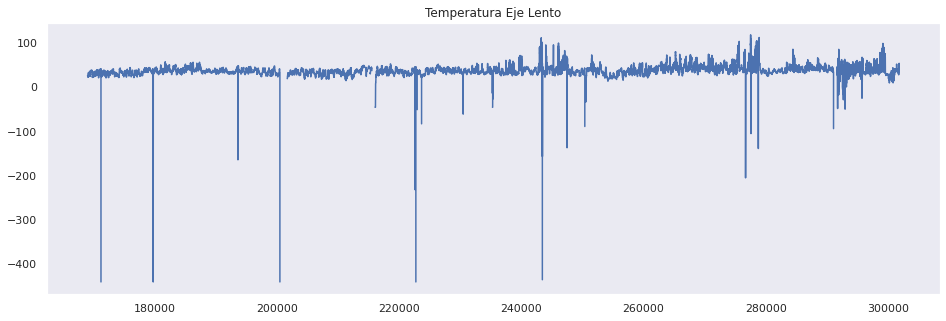

In [5]:
plt.subplots(1, figsize = (16, 5))
plt.grid()
plt.title('Temperatura Eje Lento')
#plt.plot(df_raw['TempEjeLento_1'].rolling(window=150).median())
plt.plot(df_raw['TempEjeLento_1'])

In [6]:
train_dataset = df_raw[['date_time', 'TempEjeLento_1','TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']]
train_dataset.columns = ["ds", "y",'TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']
train_dataset=train_dataset.dropna()
train_dataset.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
169056,2016-03-20 01:00:00,24.2118,5.70126,4.28948,5.25117,0.503478
169057,2016-03-20 01:10:00,24.3459,5.41323,3.90971,5.50011,0.417934
169058,2016-03-20 01:20:00,24.4673,5.06684,4.01549,5.58003,0.516092
169059,2016-03-20 01:30:00,24.3626,4.64511,4.96556,5.11137,0.556239
169060,2016-03-20 01:40:00,24.3889,4.51694,5.52982,5.01034,0.592516


In [7]:
def remove_outliers(df):
    return df[np.abs(df['y']-df['y'].mean())<=(3*df['y'].std())] 

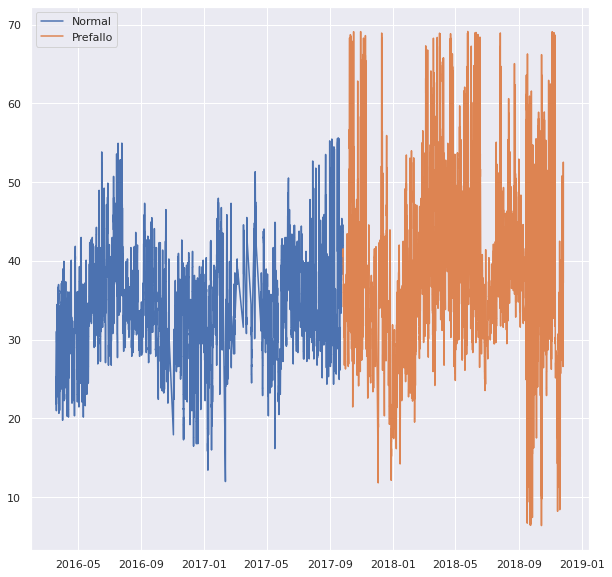

In [8]:
date = '2017-09-26'
date_fail = '2018-03-26'
data_1 = train_dataset[(train_dataset['ds'] < date)]
data_1 = remove_outliers(data_1)

data_2 = train_dataset[(train_dataset['ds'] > date)]
data_2 = remove_outliers(data_2)

data_test = train_dataset[(train_dataset['ds'] < date_fail)]
#data_test = data_test[(data_test['ds'] < date_fail)]
data_test = remove_outliers(data_test)
plt.figure(figsize=(10,10))
plt.plot(data_1['ds'],data_1['y'],label='Normal')
plt.plot(data_2['ds'],data_2['y'],label='Prefallo')
plt.legend()
plt.show()

In [9]:
#prophet_basic = Prophet(yearly_seasonality=True)
prophet_basic = Prophet()
prophet_basic.add_regressor('TempAmbMean')
prophet_basic.add_regressor('IndTurbulMean')
prophet_basic.add_regressor('VelVientoMean')
prophet_basic.add_regressor('VelVientoSdev')
prophet_basic.fit(data_1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


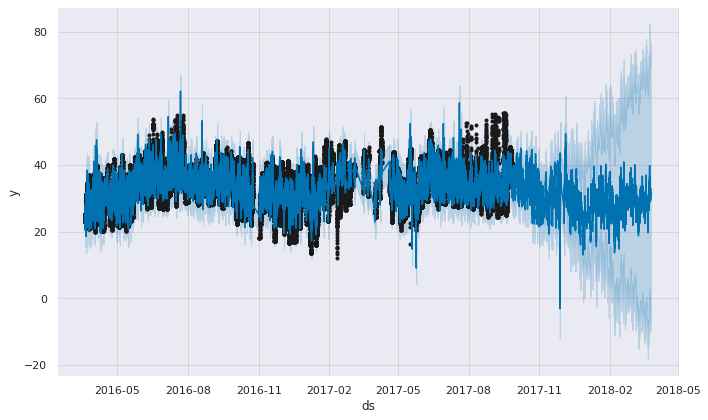

In [10]:
forecast=prophet_basic.predict(data_test.drop(columns="y"))

#Plotting the predicted data
fig1 =prophet_basic.plot(forecast)

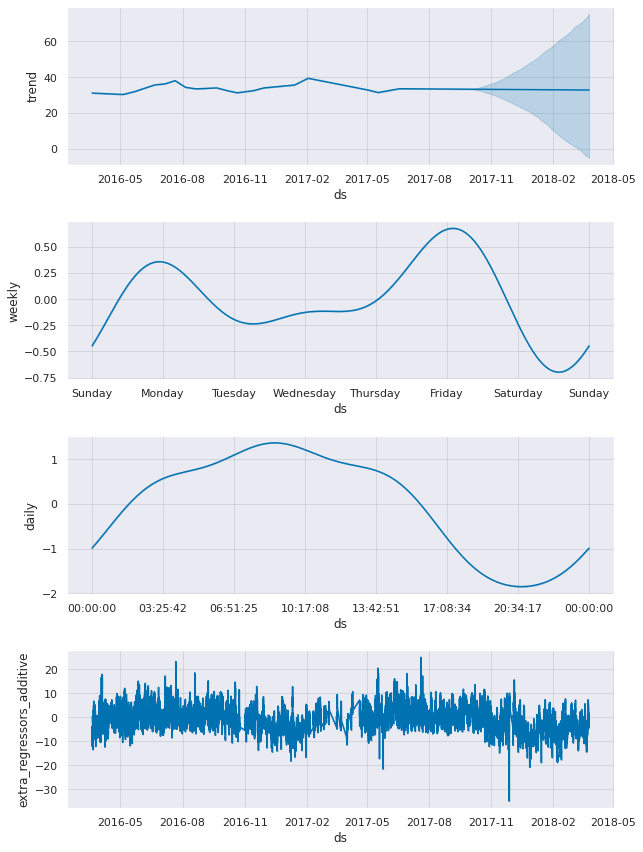

In [11]:
fig1 = prophet_basic.plot_components(forecast)

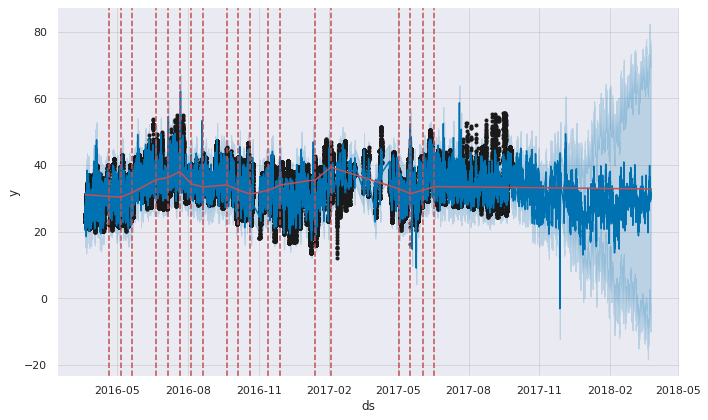

In [12]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
93924,2018-03-25 22:50:00,32.803298,-6.257355,74.876688,-4.889741,75.215588,1.837883,1.837883,1.837883,-3.046145,-3.046145,-3.046145,2.287555,2.287555,2.287555,-0.242802,-0.242802,-0.242802,-0.313885,-0.313885,-0.313885,-1.508188,-1.508188,-1.508188,0.836491,0.836491,0.836491,0.357812,0.357812,0.357812,0.0,0.0,0.0,32.489414
93925,2018-03-25 23:00:00,32.803281,-5.457568,74.550720,-4.892779,75.215989,2.267699,2.267699,2.267699,-3.070267,-3.070267,-3.070267,1.800716,1.800716,1.800716,-0.489647,-0.489647,-0.489647,-0.581969,-0.581969,-0.581969,-1.448157,-1.448157,-1.448157,0.508501,0.508501,0.508501,0.357687,0.357687,0.357687,0.0,0.0,0.0,32.221312
93926,2018-03-25 23:10:00,32.803263,-6.036441,76.228644,-4.895818,75.216390,1.681621,1.681621,1.681621,-3.118183,-3.118183,-3.118183,2.440696,2.440696,2.440696,-0.198775,-0.198775,-0.198775,-0.220236,-0.220236,-0.220236,-1.383047,-1.383047,-1.383047,0.805358,0.805358,0.805358,0.357453,0.357453,0.357453,0.0,0.0,0.0,32.583027
93927,2018-03-25 23:20:00,32.803246,-6.178270,74.357186,-4.898857,75.216791,2.070434,2.070434,2.070434,-3.166104,-3.166104,-3.166104,2.025175,2.025175,2.025175,-0.100939,-0.100939,-0.100939,-0.127323,-0.127323,-0.127323,-1.313000,-1.313000,-1.313000,0.828566,0.828566,0.828566,0.357110,0.357110,0.357110,0.0,0.0,0.0,32.675923
93928,2018-03-25 23:30:00,32.803228,-5.987585,74.389289,-4.901896,75.217192,1.939513,1.939513,1.939513,-3.214024,-3.214024,-3.214024,1.279559,1.279559,1.279559,-0.194722,-0.194722,-0.194722,-1.071247,-1.071247,-1.071247,-1.238234,-1.238234,-1.238234,-0.189674,-0.189674,-0.189674,0.356661,0.356661,0.356661,0.0,0.0,0.0,31.731981


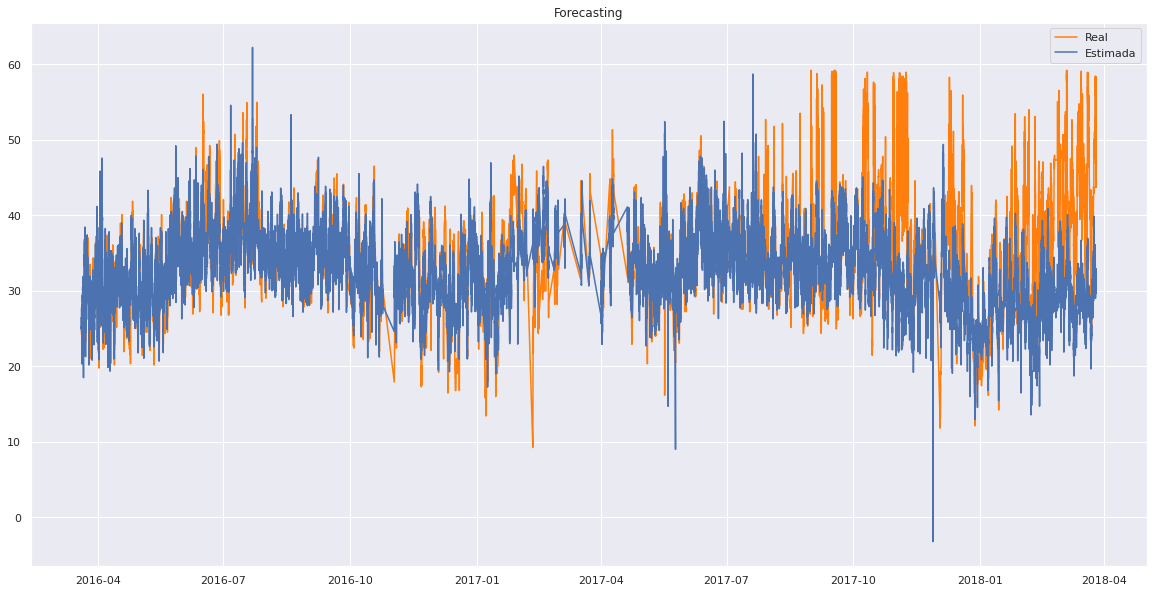

In [14]:
plt.figure(figsize=(20,10))
#plt.plot(forecast['ds'],forecast['yhat_lower'],'-r',label='Confianza')
#plt.plot(forecast['ds'],forecast['yhat_upper'],'-r')
plt.plot(data_test['ds'],data_test['y'],'tab:orange',label='Real')
plt.plot(forecast['ds'],forecast['yhat'],'b',label='Estimada')
#plt.plot(data_1['ds'],data_1['y'],'c')
plt.legend()
plt.title('Forecasting')
plt.show()

In [15]:
import numpy as np
forecast['error']= data_test['y']-forecast['yhat']

In [16]:
data_test.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
169056,2016-03-20 01:00:00,24.2118,5.70126,4.28948,5.25117,0.503478
169057,2016-03-20 01:10:00,24.3459,5.41323,3.90971,5.50011,0.417934
169058,2016-03-20 01:20:00,24.4673,5.06684,4.01549,5.58003,0.516092
169059,2016-03-20 01:30:00,24.3626,4.64511,4.96556,5.11137,0.556239
169060,2016-03-20 01:40:00,24.3889,4.51694,5.52982,5.01034,0.592516


In [17]:
forecast['y_true'] = data_test['y'].values
forecast['error'] = forecast['y_true']-forecast['yhat']

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,error,y_true
0,2016-03-20 01:00:00,31.113168,20.412694,30.485168,31.113168,31.113168,0.213540,0.213540,0.213540,-4.550901,-4.550901,-4.550901,-0.760126,-0.760126,-0.760126,0.113148,0.113148,0.113148,-5.812041,-5.812041,-5.812041,-0.425927,-0.425927,-0.425927,-4.984338,-4.984338,-4.984338,-0.401777,-0.401777,-0.401777,0.0,0.0,0.0,25.301127,-1.089327,24.2118
1,2016-03-20 01:10:00,31.113037,19.790070,29.821381,31.113037,31.113037,-0.243652,-0.243652,-0.243652,-4.659394,-4.659394,-4.659394,-0.555351,-0.555351,-0.555351,0.159016,0.159016,0.159016,-6.024951,-6.024951,-6.024951,-0.331556,-0.331556,-0.331556,-5.299381,-5.299381,-5.299381,-0.394014,-0.394014,-0.394014,0.0,0.0,0.0,25.088086,-0.742186,24.3459
2,2016-03-20 01:20:00,31.112905,20.073025,30.371319,31.112905,31.112905,-0.116307,-0.116307,-0.116307,-4.789869,-4.789869,-4.789869,-0.489610,-0.489610,-0.489610,0.106385,0.106385,0.106385,-5.914586,-5.914586,-5.914586,-0.238988,-0.238988,-0.238988,-5.289401,-5.289401,-5.289401,-0.386197,-0.386197,-0.386197,0.0,0.0,0.0,25.198319,-0.731019,24.4673
3,2016-03-20 01:30:00,31.112774,20.553149,31.006639,31.112774,31.112774,1.027451,1.027451,1.027451,-4.948722,-4.948722,-4.948722,-0.875123,-0.875123,-0.875123,0.084859,0.084859,0.084859,-5.238789,-5.238789,-5.238789,-0.148926,-0.148926,-0.148926,-4.711536,-4.711536,-4.711536,-0.378327,-0.378327,-0.378327,0.0,0.0,0.0,25.873985,-1.511385,24.3626
4,2016-03-20 01:40:00,31.112643,21.424948,31.383582,31.112643,31.112643,1.706745,1.706745,1.706745,-4.997000,-4.997000,-4.997000,-0.958229,-0.958229,-0.958229,0.065407,0.065407,0.065407,-4.615511,-4.615511,-4.615511,-0.062028,-0.062028,-0.062028,-4.183077,-4.183077,-4.183077,-0.370406,-0.370406,-0.370406,0.0,0.0,0.0,26.497133,-2.108233,24.3889


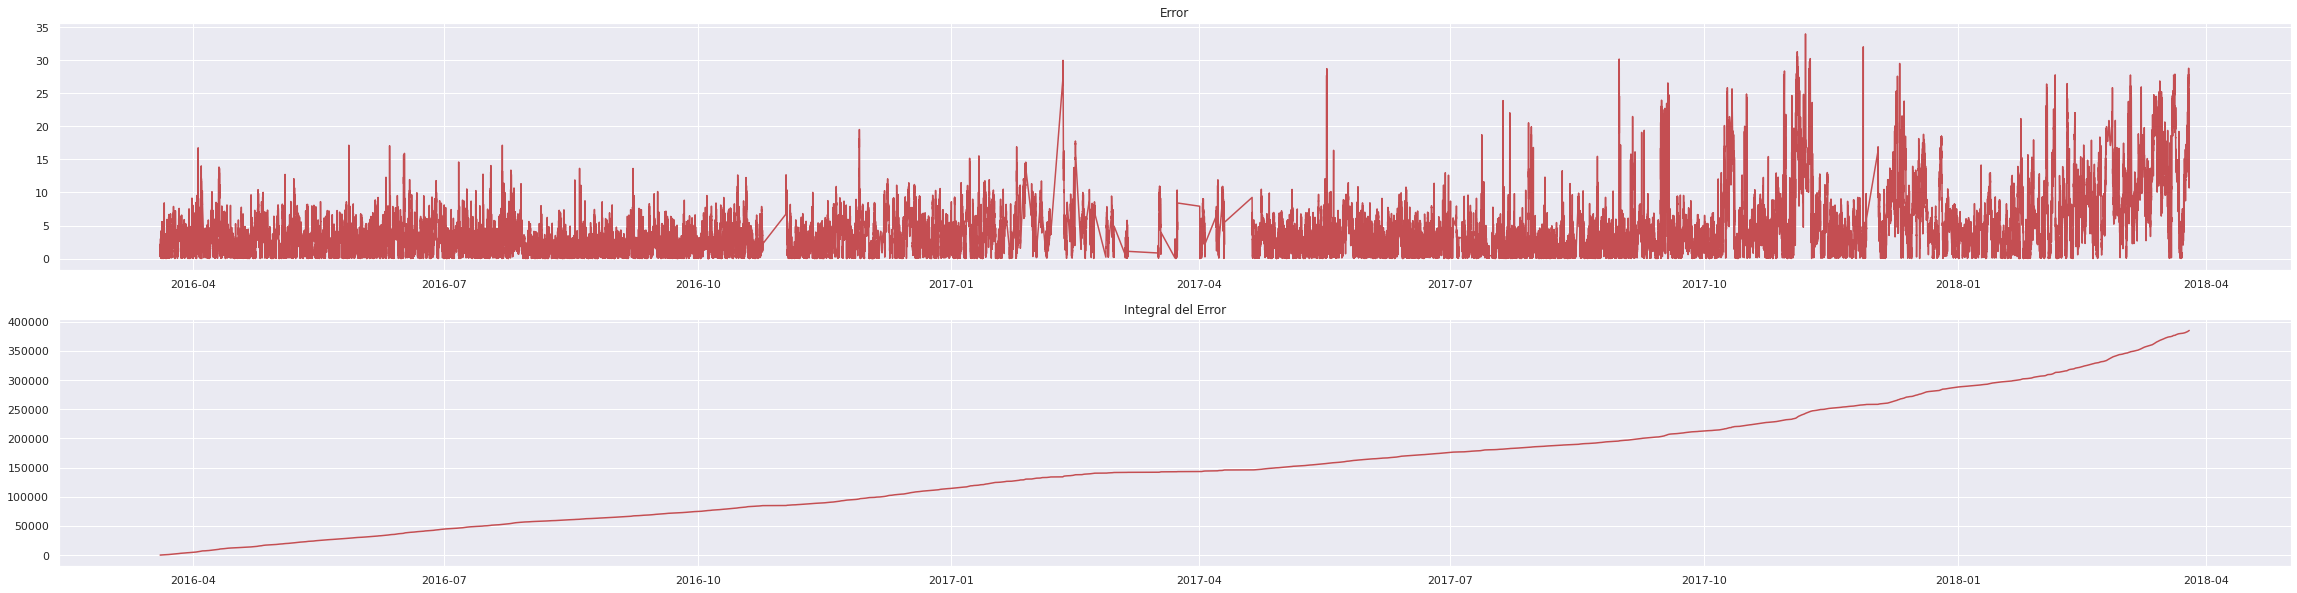

In [19]:
plt.figure(figsize=(40,10))
plt.subplot(211)
plt.title('Error')
plt.plot(forecast['ds'],forecast['error'].abs(),'r')
plt.subplot(212)
plt.title('Integral del Error')
plt.plot(forecast['ds'],forecast['error'].abs().cumsum(),'r')

plt.show()

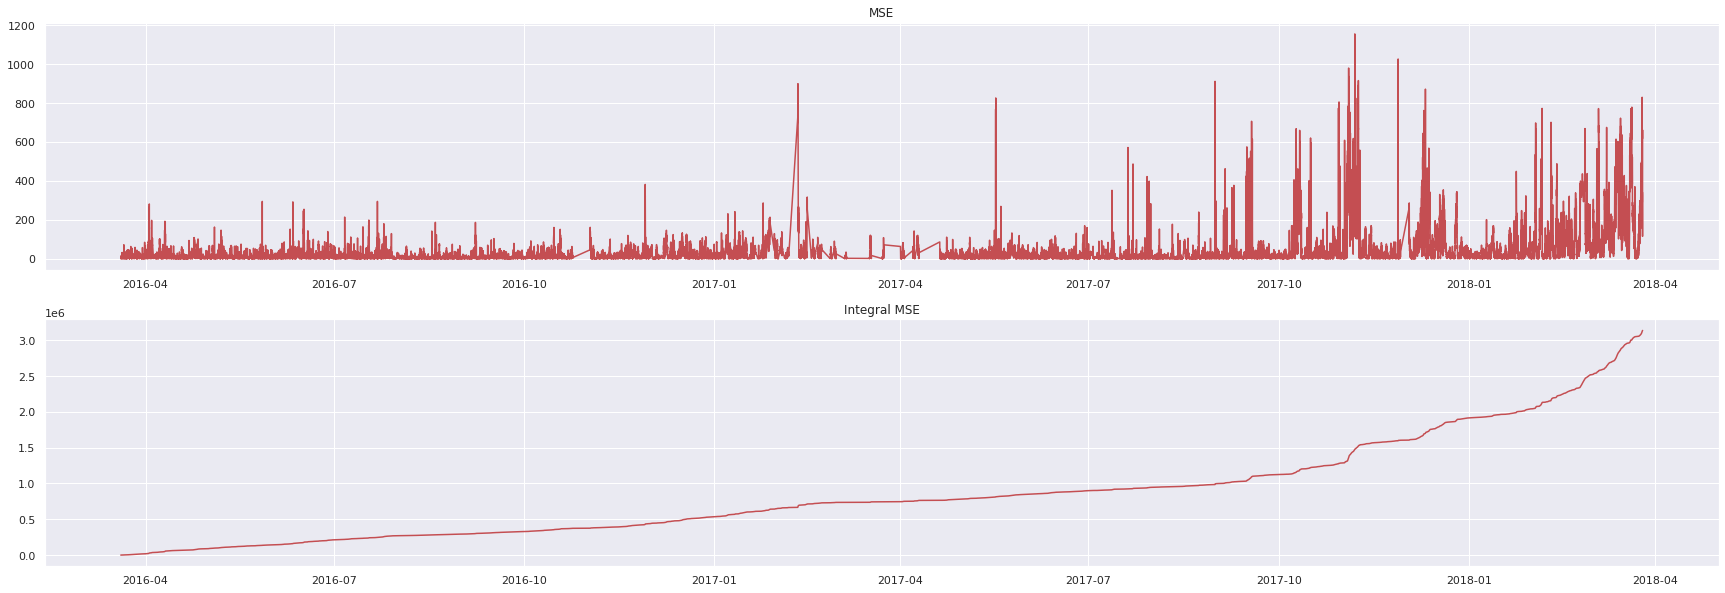

In [20]:
signal = forecast['error']**2
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot(forecast['ds'],signal,'r')
plt.title('MSE')
plt.subplot(212)
signal=forecast['error']**2
plt.plot(forecast['ds'],signal.cumsum(),'r')
plt.title('Integral MSE')
plt.show()